In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from torchnet.meter import MovingAverageValueMeter
from tqdm import tqdm

from deeplab_vandaele import load_model
from utils import get_device
from dataset import RiverDataset
from torch.utils.data import random_split, DataLoader
from torchvision.transforms.functional import to_pil_image
from omegaconf import OmegaConf
from scipy import ndimage
from deeplab.utils import DenseCRF, PolynomialLR, scores
from PIL import Image

In [2]:
device = get_device()

Device: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
config_path = './weights/water.yaml'

CONFIG = OmegaConf.load(config_path)
torch.backends.cudnn.benchmark = True

## Import Dataset and Model 

In [4]:
dataset = RiverDataset("images")

# split the dataset in train and test set
torch.manual_seed(1)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

# define training and validation data loaders
dataloader_train = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = load_model(device)

## Setup Optimizer and Loss Function

In [10]:
# Loss definition
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [11]:
def get_params(model, key):
    # For Dilated FCN
    if key == "1x":
        for m in model.named_modules():
            if "layer" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    for p in m[1].parameters():
                        yield p
    # For conv weight in the ASPP module
    if key == "10x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].weight
    # For conv bias in the ASPP module
    if key == "20x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].bias

# Optimizer
optimizer = torch.optim.SGD(
    # cf lr_mult and decay_mult in train.prototxt
    params=[
        {
            "params": get_params(model.module, key="1x"),
            "lr": CONFIG.SOLVER.LR,
            "weight_decay": CONFIG.SOLVER.WEIGHT_DECAY,
        },
        {
            "params": get_params(model.module, key="10x"),
            "lr": 10 * CONFIG.SOLVER.LR,
            "weight_decay": CONFIG.SOLVER.WEIGHT_DECAY,
        },
        {
            "params": get_params(model.module, key="20x"),
            "lr": 20 * CONFIG.SOLVER.LR,
            "weight_decay": 0.0,
        },
    ],
    momentum=CONFIG.SOLVER.MOMENTUM,
)

In [12]:
# Learning rate scheduler
scheduler = PolynomialLR(
    optimizer=optimizer,
    step_size=CONFIG.SOLVER.LR_DECAY,
    iter_max=CONFIG.SOLVER.ITER_MAX,
    power=CONFIG.SOLVER.POLY_POWER,
)

In [13]:
# Setup loss logger
writer = SummaryWriter(os.path.join(CONFIG.EXP.OUTPUT_DIR, "logs", CONFIG.EXP.ID))
average_loss = MovingAverageValueMeter(CONFIG.SOLVER.AVERAGE_LOSS)

In [14]:
def makedirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

# Path to save models
checkpoint_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    CONFIG.MODEL.NAME.lower()
)

makedirs(checkpoint_dir)

print("Checkpoint dst:", checkpoint_dir)

Checkpoint dst: water_output\deeplabv2_resnet101_msc


In [15]:
def resize_labels(labels, size):
    """
    Downsample labels for 0.5x and 0.75x logits by nearest interpolation.
    Other nearest methods result in misaligned labels.
    -> F.interpolate(labels, shape, mode='nearest')
    -> cv2.resize(labels, shape, interpolation=cv2.INTER_NEAREST)
    """
    new_labels = []
    for label in labels:
        label = label.float().numpy()
        label = Image.fromarray(label).resize(size, resample=Image.NEAREST)
        new_labels.append(np.asarray(label))
    new_labels = torch.LongTensor(np.array(new_labels))
    return new_labels

## Training

In [16]:
# Freeze the batch norm pre-trained on COCO
model.train()
model.module.base.freeze_bn()

In [17]:
loader_iter = iter(dataloader_train)

for iteration in tqdm(
    range(1, CONFIG.SOLVER.ITER_MAX + 1),
    total=CONFIG.SOLVER.ITER_MAX,
    dynamic_ncols=True,
):

    # Clear gradients (ready to accumulate)
    optimizer.zero_grad()

    loss = 0
    for _ in range(CONFIG.SOLVER.ITER_SIZE):
        try:
            _, images, labels = next(loader_iter)
        except:
            loader_iter = iter(dataloader_train)
            _, images, labels = next(loader_iter)

        # Propagate forward
        logits = model(images.to(device))

        # Loss
        iter_loss = 0
        for logit in logits:
            # Resize labels for {100%, 75%, 50%, Max} logits
            _, _, H, W = logit.shape
            labels_ = resize_labels(labels, size=(W, H))
            iter_loss += criterion(logit, labels_.to(device))

        # Propagate backward (just compute gradients)
        iter_loss /= CONFIG.SOLVER.ITER_SIZE
        iter_loss.backward()

        loss += float(iter_loss)

    average_loss.add(loss)

    # Update weights with accumulated gradients
    optimizer.step()

    # Update learning rate
    scheduler.step(epoch=iteration)

    # TensorBoard
    if iteration % CONFIG.SOLVER.ITER_TB == 0:
        writer.add_scalar("loss/train", average_loss.value()[0], iteration)
        for i, o in enumerate(optimizer.param_groups):
            writer.add_scalar("lr/group_{}".format(i), o["lr"], iteration)
        for i in range(torch.cuda.device_count()):
            writer.add_scalar(
                "gpu/device_{}/memory_cached".format(i),
                torch.cuda.memory_cached(i) / 1024 ** 3,
                iteration,
            )

        if False:
            for name, param in model.module.base.named_parameters():
                name = name.replace(".", "/")
                # Weight/gradient distribution
                writer.add_histogram(name, param, iteration, bins="auto")
                if param.requires_grad:
                    writer.add_histogram(
                        name + "/grad", param.grad, iteration, bins="auto"
                    )

    # Save a model
    if iteration % CONFIG.SOLVER.ITER_SAVE == 0:
        torch.save(
            model.module.state_dict(),
            os.path.join(checkpoint_dir, "checkpoint_{}.pth".format(iteration)),
        )

  0%|                                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings

## Test Model

In [18]:
# Path to save logits
logit_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    "features",
    CONFIG.MODEL.NAME.lower(),
    "logit",
)

makedirs(logit_dir)
print("Logit dst:", logit_dir)

Logit dst: water_output\features\deeplabv2_resnet101_msc\logit


In [19]:
# Path to save scores
save_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    "scores",
    CONFIG.MODEL.NAME.lower(),
)
makedirs(save_dir)
save_path = os.path.join(save_dir, "scores.json")
print("Score dst:", save_path)

Score dst: water_output\scores\deeplabv2_resnet101_msc\scores.json


In [20]:
model.eval()

preds, gts = [], []
for image_ids, images, gt_labels in tqdm(
    dataloader_test, total=len(dataloader_test), dynamic_ncols=True
):
    # Image
    images = images.to(device)

    # Forward propagation
    logits = model(images)

    # Save on disk for CRF post-processing
    for image_id, logit in zip(image_ids, logits):
        filename = os.path.join(logit_dir, image_id + ".npy")
        np.save(filename, logit.detach().cpu().numpy())

    # Pixel-wise labeling
    _, H, W = gt_labels.shape
    logits = F.interpolate(
        logits, size=(H, W), mode="bilinear", align_corners=False
    )
    probs = F.softmax(logits, dim=1)
    labels = torch.argmax(probs, dim=1)

    preds += list(labels.cpu().numpy())
    gts += list(gt_labels.numpy())

# Pixel Accuracy, Mean Accuracy, Class IoU, Mean IoU, Freq Weighted IoU
score = scores(gts, preds, n_class=CONFIG.DATASET.N_CLASSES)

with open(save_path, "w") as f:
    json.dump(score, f, indent=4, sort_keys=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:36<00:00,  1.97it/s]


In [23]:
score

{'Pixel Accuracy': 0.9640611135223766,
 'Mean Accuracy': 0.9509654605268659,
 'Frequency Weighted IoU': 0.930986246046564,
 'Mean IoU': 0.9134060218574618,
 'Class IoU': {0: 0.8748020757996138, 1: 0.9520099679153098}}

## Visualize an Image

In [5]:
img_id, img, mask = dataset.__getitem__(165)

In [8]:
img.shape

(3, 360, 640)

In [9]:
mask.shape

(360, 640)

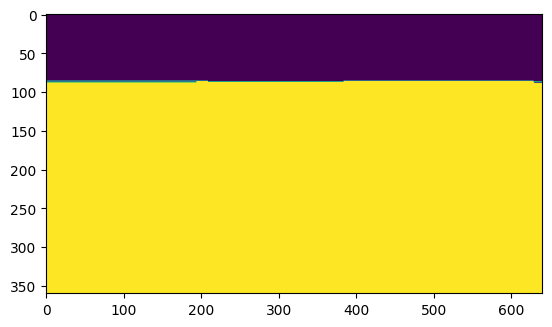

In [6]:
plt.imshow(mask)

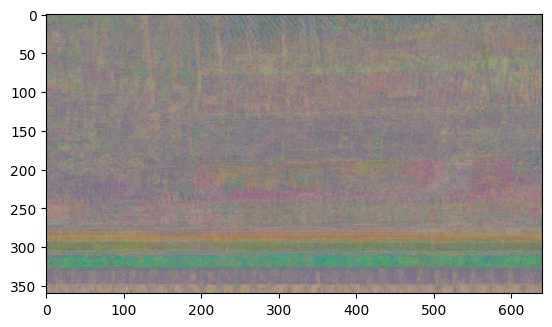

In [7]:
plt.imshow(to_pil_image(torch.Tensor(img)))